In [4]:
import functools
import numpy as np
import jax 
import optax
import haiku as hk
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context='talk', font_scale=1.0)

import utils

In [5]:
%matplotlib inline

## Generate Data

In [251]:
def load_dataset(x_range, b0, w0, n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1 + np.sin(x)) + b0) + eps
    y = (y-y.mean()) / y.std()
    xm, xs = x.mean(), x.std()
    x = x[..., None]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., None]
    
    def normalize(x):
        return (x - xm) / xs
    return (y.astype(np.float32), normalize(x).astype(np.float32), 
            normalize(x_tst).astype(np.float32))

def dataset(x, y, batch_size):
    ids = np.arange(len(x))
    while True:
        ids = np.random.choice(ids, batch_size, False)
        yield x[ids].astype(np.float32), y[ids].astype(np.float32)
        
w0 = 0.125
b0 = 0.
x_range = [-20, 60]
batch_size = 32
y, x, x_tst = load_dataset(x_range, b0, w0)
data = iter(dataset(x, y, batch_size))

## Plotting

In [7]:
def plot(x, y, x_tst, yhats):
    plt.figure(figsize=[15, 4.0], dpi= 100)  # inches
    plt.plot(x, y, 'b.', label='observed')

    avgm = np.zeros_like(x_tst[..., 0])
    for i, yhat in enumerate(yhats):
        m = np.squeeze(yhat.mean())
        s = np.squeeze(yhat.stddev())
        if i < 15:
            plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
            plt.plot(x_tst, m + 3 * s, 'g', linewidth=0.5, label='ensemble means + 3 ensemble stdev' if i == 0 else None)
            plt.plot(x_tst, m - 3 * s, 'g', linewidth=0.5, label='ensemble means - 3 ensemble stdev' if i == 0 else None)
        avgm += m
    plt.plot(x_tst, avgm / len(yhats), 'r', label='overall mean', linewidth=4)
    ax = plt.gca()
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(0.95, 0.5))
    plt.tight_layout()

## Train with Bayes-by-Backprop

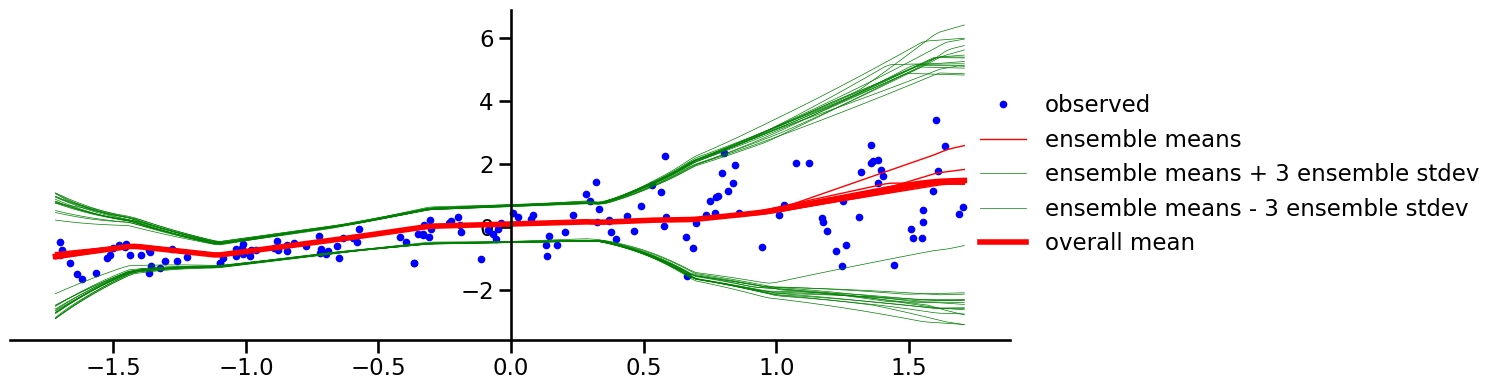

In [33]:
from bayes_by_backprop import BayesByBackprop
model = BayesByBackprop(x[:batch_size], 20, functools.partial(net_fn, sd_scale=0.1), beta=1e-2, prior_stddev=1.0,
                       posterior_stddev=0.1)
opt = optax.flatten(optax.adam(1e-3))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(20000):
    model.params, opt_state = update(*next(data), model.params, next(keys), opt_state)
yhats_bbb = model.predict(x_tst)
plot(x, y, x_tst, yhats_bbb)

As excepted, training with Bayes-by-Backprop leads to an underfitting model. By reducing the standard deviation of the posterior, and artificially zeroing out the kl divergence term in ELBO, we optimize only for the reconstruction term. We can see that the method still underfits, but performs considerably better.

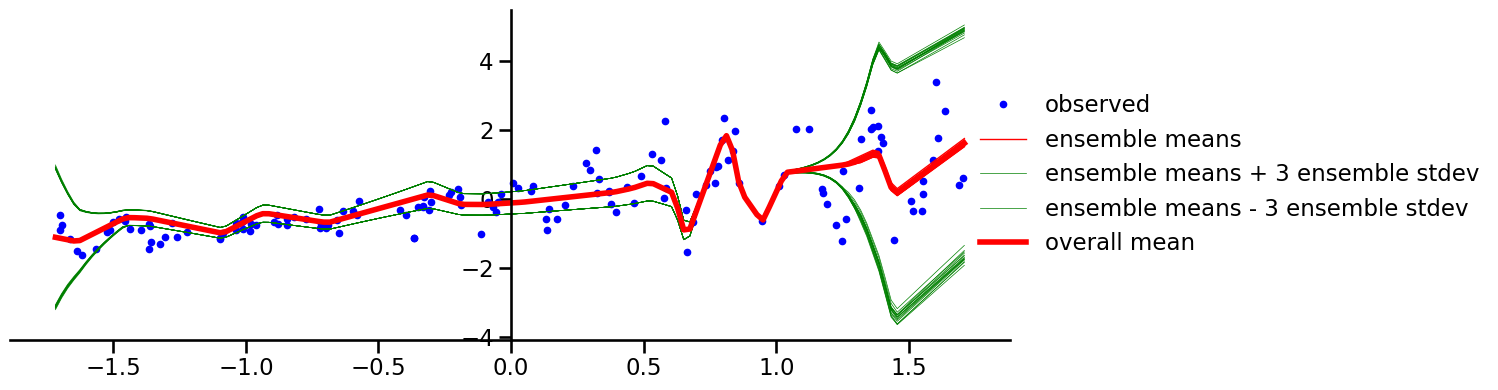

In [39]:
model = BayesByBackprop(x[:batch_size], 20, functools.partial(net_fn, sd_scale=0.1), beta=0.0, prior_stddev=1.0,
                       posterior_stddev=1e-8)
opt = optax.flatten(optax.adam(1e-3))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(20000):
    model.params, opt_state = update(*next(data), model.params, next(keys), opt_state)
yhats_bbb = model.predict(x_tst)
plot(x, y, x_tst, yhats_bbb)

## Prior Predictive Check

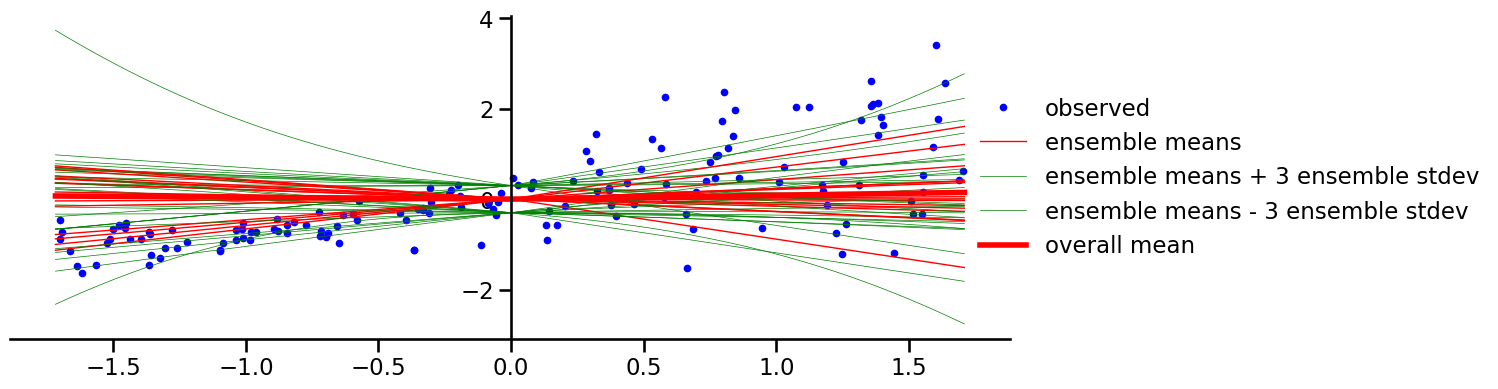

In [34]:
from f_povi import FunctionalParticleOptimization
net_fn = functools.partial(utils.net, n_layers=2, n_hidden=50)
model = FunctionalParticleOptimization(x[:batch_size], 20, net_fn)
plot(x, y, x_tst, model.predict(x_tst))

## Train with Functional Particle Optimization Variational Inference (f-POVI)

(-3.0, 3.0)

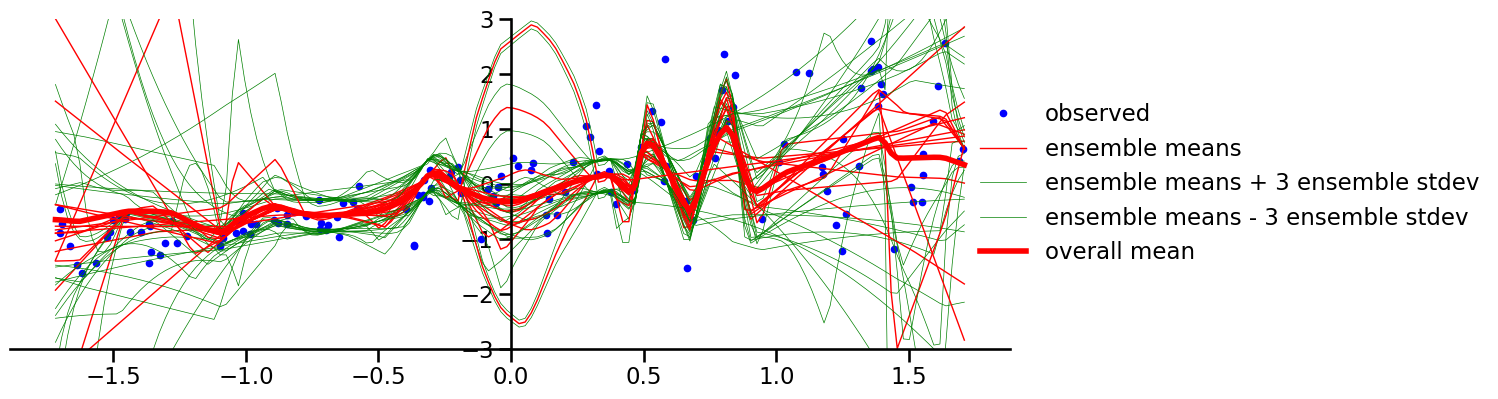

In [9]:
model = FunctionalParticleOptimization(x[:batch_size], 20, net_fn, n_prior_particles=80)
opt = optax.flatten(optax.adam(1e-3))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(20000):
    model.params, opt_state = update(*next(data), model.params, next(keys), opt_state)
yhats_fpovi = model.predict(x_tst)
plot(x, y, x_tst, yhats_fpovi)
plt.ylim(-3, 3)

The approximate posterior appears to be underfitting in the $x\in (1,2)$ region. The following experiment with point estimation suggests this may be due to the limited capacity of the NN architecture:

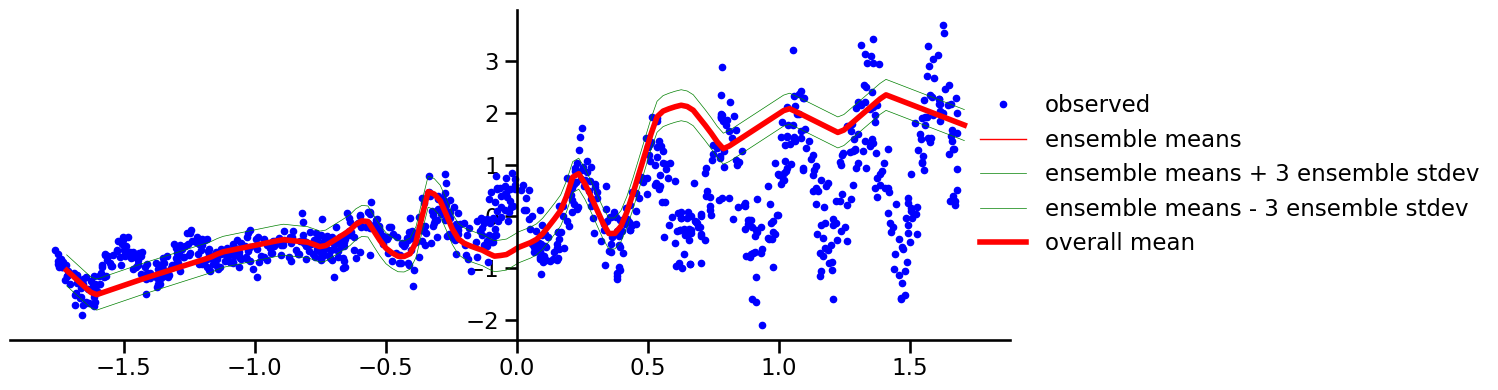

In [10]:
yl, xl = load_dataset(x_range, b0, w0, n=1000)[:2]
large_data = iter(dataset(xl, yl, batch_size))

model = FunctionalParticleOptimization(
    xl[:batch_size], 1,
    functools.partial(utils.net, n_layers=2, n_hidden=100, sd_min=0.1, sd_max=0.1))
def vacuous_prior(inp):
    class A:
        def log_prob(self, inp):
            return jax.numpy.zeros((inp.shape[0],))
    return A()
model._prior = vacuous_prior
opt = optax.flatten(optax.adam(0.004))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(10000):
    model.params, opt_state = update(*next(large_data), model.params, next(keys), opt_state)
yhats_fpovi = model.predict(x_tst)
plot(xl, yl, x_tst, yhats_fpovi)

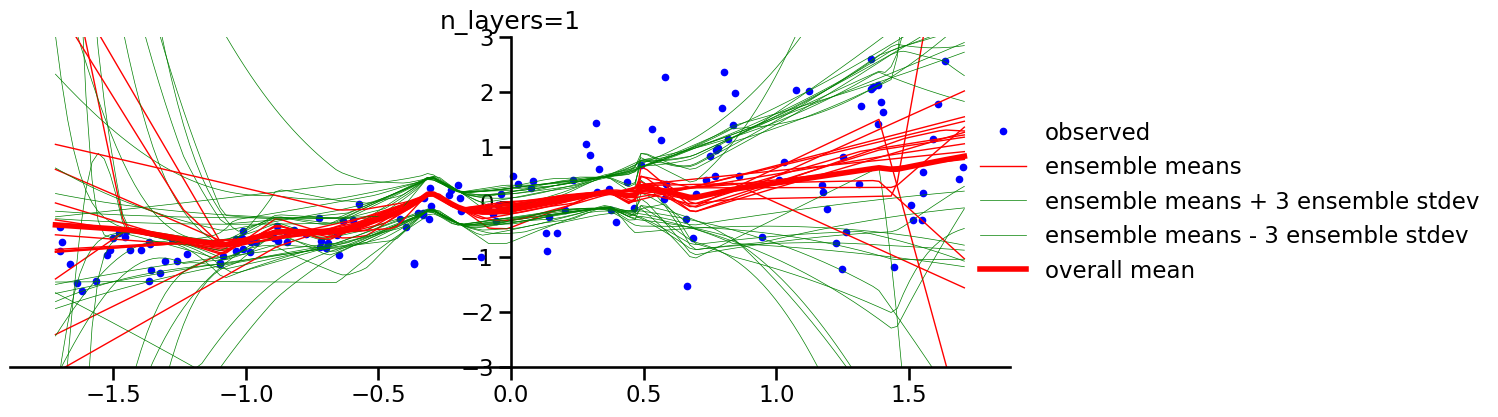

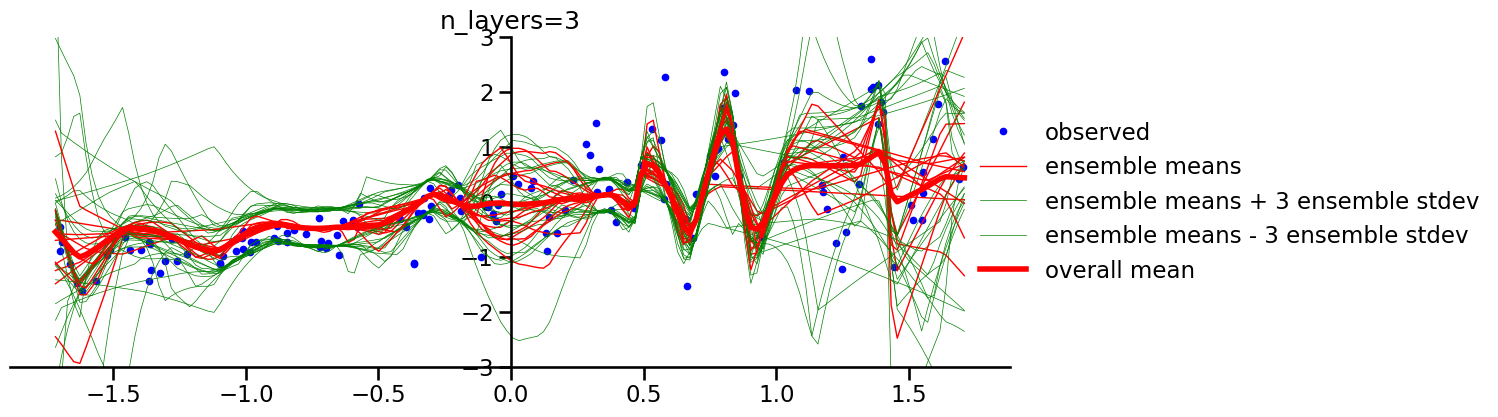

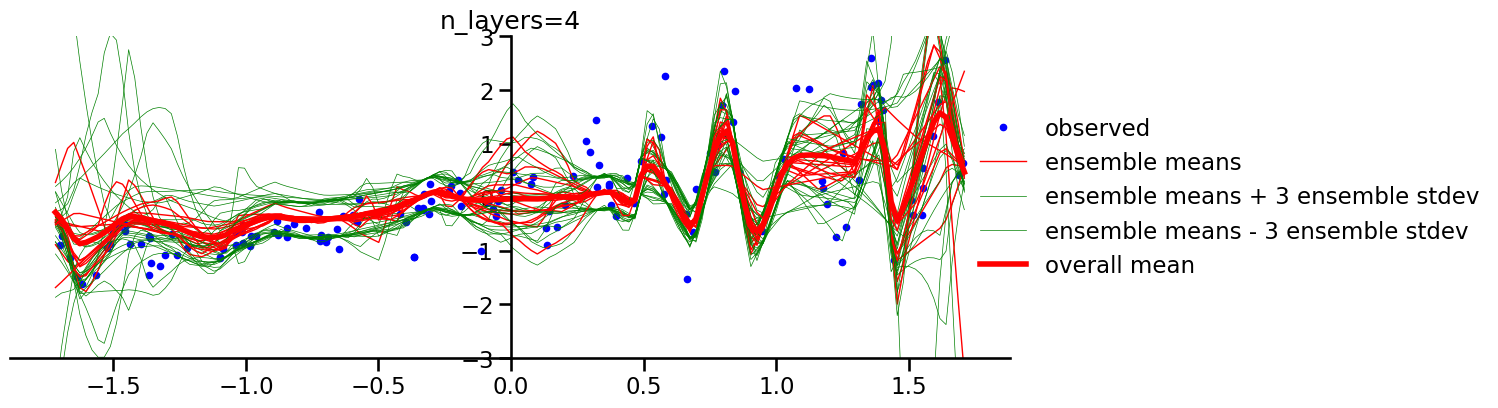

In [11]:
for n_layers in [1, 3, 4]:
    model = FunctionalParticleOptimization(x[:batch_size], 20, functools.partial(utils.net, n_layers=n_layers), n_prior_particles=80)
    opt = optax.flatten(optax.adam(1e-3))
    keys = hk.PRNGSequence(jax.random.PRNGKey(42))
    opt_state = opt.init(model.params)

    for step in range(20000):
        model.params, opt_state = update(*next(data), model.params, next(keys), opt_state)
    yhats_fpovi = model.predict(x_tst)
    plot(x, y, x_tst, yhats_fpovi)
    plt.ylim(-3, 3)
    plt.title(f'n_layers={n_layers}')

As we observe, by increasing the number of layers, the posterior is capable of fitting the observed outputs $y$ which correspond to $x \in (1, 2)$.

## Train with (not-bootstrapped) Ensembles

We omit bootstrapping the batches. This makes training slightly more straightforward although less correct as the particles in the ensemble can now become correlated.

(-3.0, 3.0)

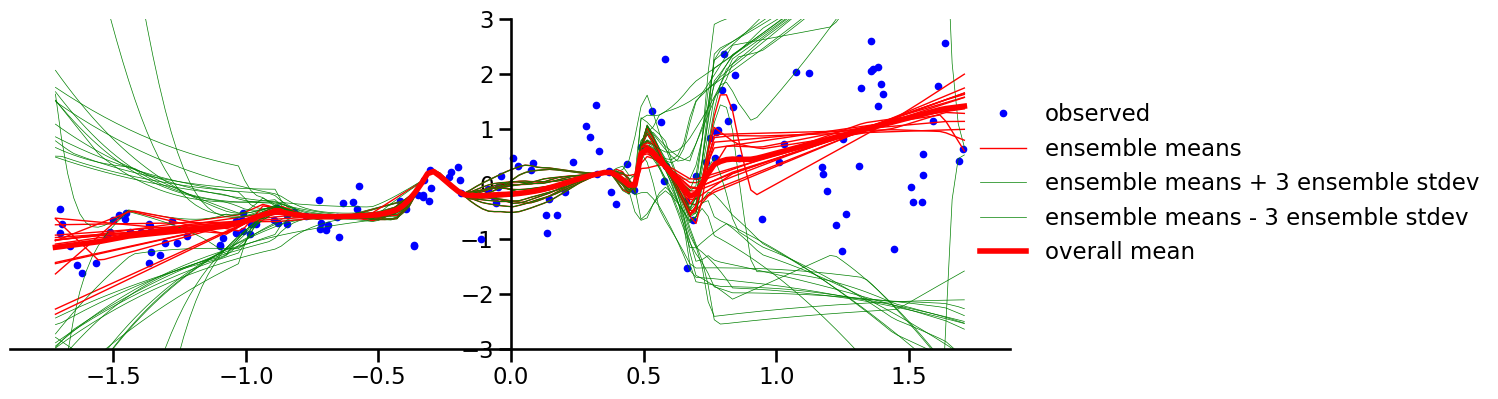

In [32]:
from ensembles import Ensemble
model = Ensemble(x[:batch_size], 20, net_fn)
opt = optax.flatten(optax.adam(1e-3))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(20000):
    model.params, opt_state = update(*next(data), model.params, next(keys), opt_state)
yhats_ensemble = model.predict(x_tst)
plot(x, y, x_tst, yhats_ensemble)
plt.ylim(-3, 3)

As seen, the _epistemic_ uncertainty with ensembles is much lower while prediction accuracy is not necessary good; for instance, compare with the functional particle optimization variational inference (f-POVI) algorithm with ```n_layers = 4```, and see that the model underfits while being confidence (which is bad.)

## Fitting the data with a Gaussian Process

Importantly, a GP does not handle heteroscedastic noise 'out-of-the-box'. However, after some hyperparameters tuning, it seems that this model fits the data very well.

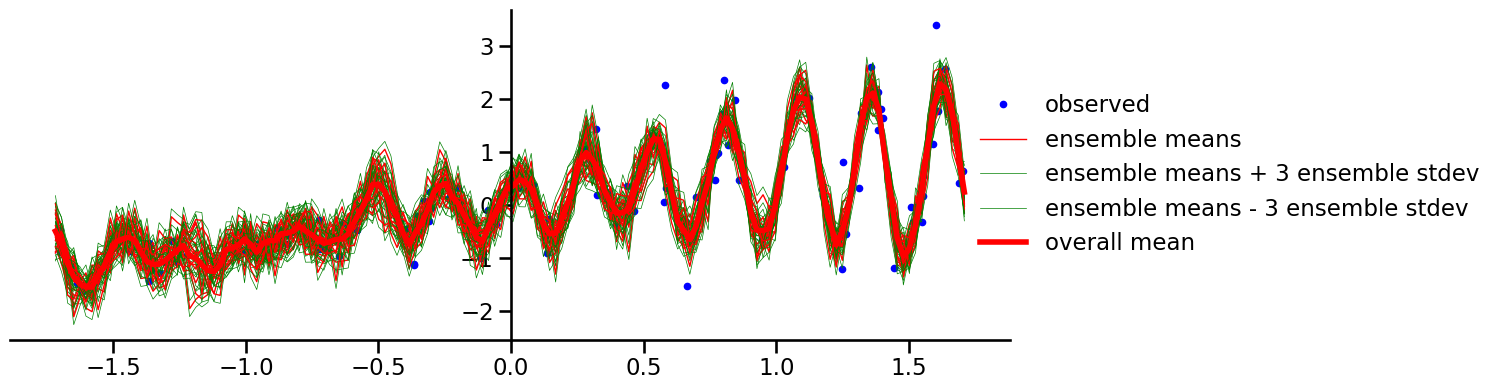

In [584]:
def kernel(a, l):
    return tfp.math.psd_kernels.ExpSinSquared(a, l, 5.0)

noise = 0.05
gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel(1.0, 0.1),
        index_points=x_tst,
        observation_noise_variance=noise,
        observation_index_points=x,
        observations=y)

samples = gprm.sample(20, seed=jax.random.PRNGKey(666))
plot(x, y, x_tst, utils.to_list_preds(samples, noise * jnp.ones_like(samples)))

## Use a GP prior for f-POVI

First let's inspect the GP from the previous section as a prior.

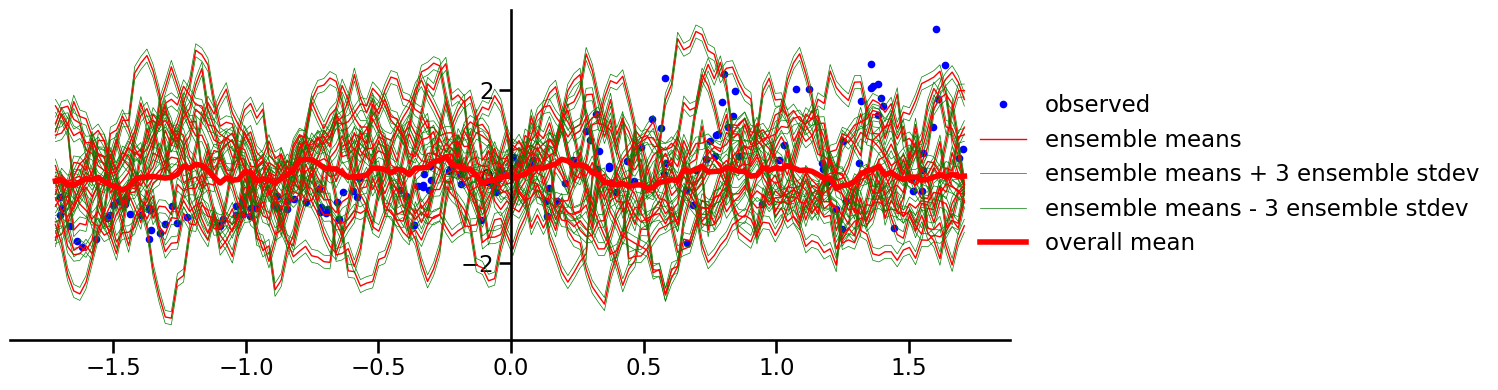

In [592]:
def gp_prior(index_points):
    gp = tfd.GaussianProcess(kernel=kernel(1.0, 0.1),
                        index_points=index_points,
                        observation_noise_variance=0.05,
                        jitter=1e-4)
    old_log_prob = gp.log_prob
    def log_prob(x):
        return old_log_prob(x.transpose())
    gp.log_prob = log_prob
    return gp

samples = gp_prior(x_tst).sample(20, seed=jax.random.PRNGKey(666))
plot(x, y, x_tst, utils.to_list_preds(samples, jnp.ones_like(samples) * 0.05))

Now, let's run f-POVI with this GP as a prior

(-3.0, 3.0)

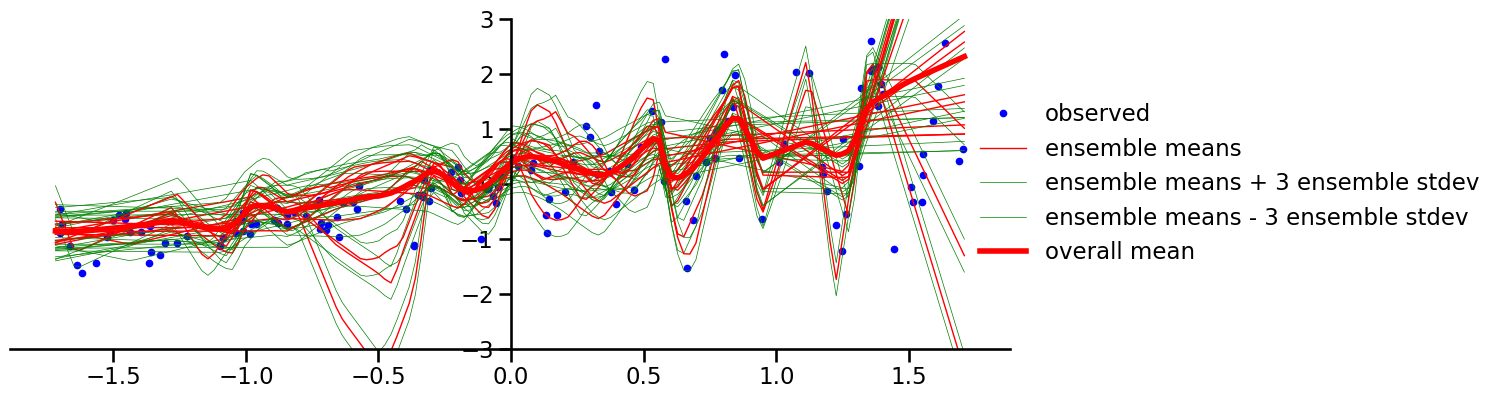

In [591]:
model = FunctionalParticleOptimization(x[:batch_size], 20, functools.partial(net_fn, sd_min=0.01, sd_max=0.1, sd_scale=0.1))
opt = optax.flatten(optax.adam(1e-3))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

model._prior = gp_prior

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(20000):
    model.params, opt_state = update(*next(data), model.params, next(keys), opt_state)
yhats_fpovi = model.predict(x_tst)
plot(x, y, x_tst, yhats_fpovi)
plt.ylim(-3, 3)